# Analysis of California Housing Data from the 1990 Census
_Raghav Chanchani_

The goal of this exercise is to develop a regression algorithm to predict home prices as accurately as possible. The process for the analysis of the data and evaluation of different estimators is as follows:
1. Import necessary libraries
2. Import dataset
3. Visualize data to develop high-level idea of datatypes, distributions, and formulate hypotheses
    1. Map several features of interest in a geographic context (specific to datasets with location data)
    2. Show relationships between variables
4. Determine variance inflation
5. Prune features
6. Select model
7. Evaluate
8. Repeat steps 6 & 7 **(use nested cross validation to streamline)**
9. State conclusions

Various regression algorithms are evaluated (reasons for selecting these models will be addressed in cells where they are declared):
   - multiple linear regression
   - regularized multiple linear regression
   - stochastic gradient descent with a least-squares error surface
   - random forest regressor
   - histogram gradient boosted regression forest

The estimators are optimized using cross validation and evaluated with three visualizations:
1. histogram of residuals
3. a scatter plot of residuals vs. predicted values

## Import Packages and the Dataset, and Customize Warning Reports

In [1]:
import pandas as pd
from sklearn import preprocessing, ensemble, decomposition
import sklearn.model_selection as ms
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.decomposition import PCA
import sklearn.linear_model as lm
import sklearn.metrics as sklm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.stats as ss
import math
import warnings
from sklearn.datasets import fetch_california_housing

%matplotlib inline

In [2]:
warnings.simplefilter('ignore') # suppress warnings
houses = fetch_california_housing() # get dataset
print(houses.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

## Preview the Data

In [3]:
cols = houses.feature_names # get feature labels
house_df = pd.DataFrame(columns = cols, data = houses.data) # construct dataframe
house_df.MedInc = house_df.MedInc*1e04
labels = (houses.target)*1e05
cols = house_df.columns
num_cols = len(cols) # or house_df.shape[1]
num_rows = houses.data.shape[0] # or house_df.shape[0], len(house_df.index)
house_df.describe()

print("Median home value: {0}".format(np.median(labels)))
print("Maximum home value: {0}".format(labels.max()))
print("Number of Blocks with Median Home Value > $400,000: {0}".format(sum(labels > (4*1e5))))
house_df.head()

Median home value: 179700.0
Maximum home value: 500000.99999999994
Number of Blocks with Median Home Value > $400,000: 1744


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,83252.0,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,83014.0,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,72574.0,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,56431.0,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,38462.0,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


**Note** The df_name.describe() method is only useful for numerical data (aside from counts of categorical data) because it shows values such as average, standard deviation, and quantile values which do not exist for categorical values.

In [4]:
house_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,38706.710029,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,18998.217179,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,4999.000000,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,25634.000000,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,35348.000000,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,47432.500000,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,150001.000000,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


## Visualize the Dataset

### View Features of Interest from a More Intuitive Perspective

Choosing to examine features in a map suits this dataset because it provides a unique way of organizing data in a way that may motivate hypotheses because this way of viewing information is more intuitive than a histogram, for example.

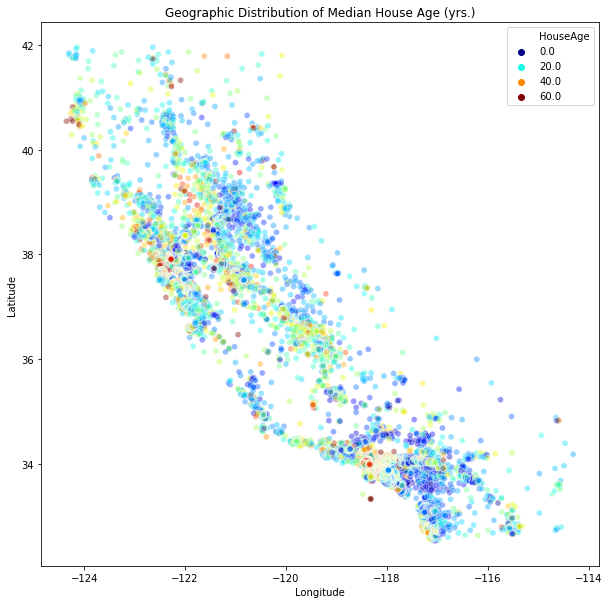

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plot = sns.scatterplot(x='Longitude', y='Latitude', data=house_df, hue='HouseAge',
                palette='jet', alpha=0.4, ax=ax)
ax.set_title('Geographic Distribution of Median House Age (yrs.)')
fig.show()

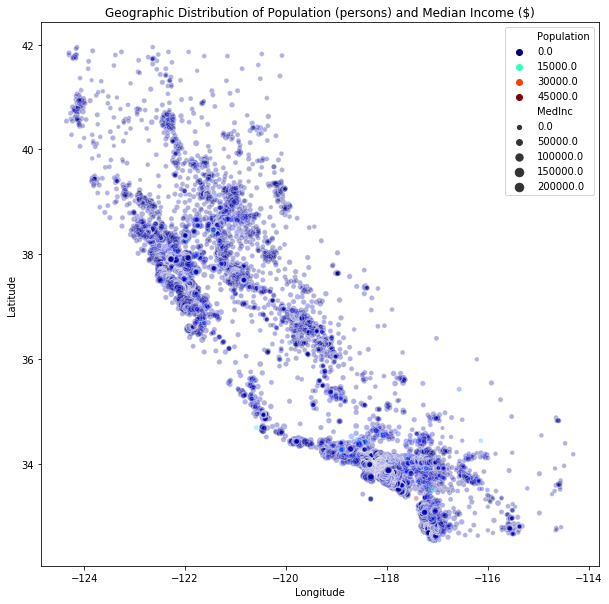

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
sns.scatterplot(x='Longitude', y='Latitude', data=house_df, size="MedInc",
                hue='Population', palette='jet', alpha=0.3, ax=ax)
ax.set_title('Geographic Distribution of Population (persons) and Median Income ($)')
fig.show()

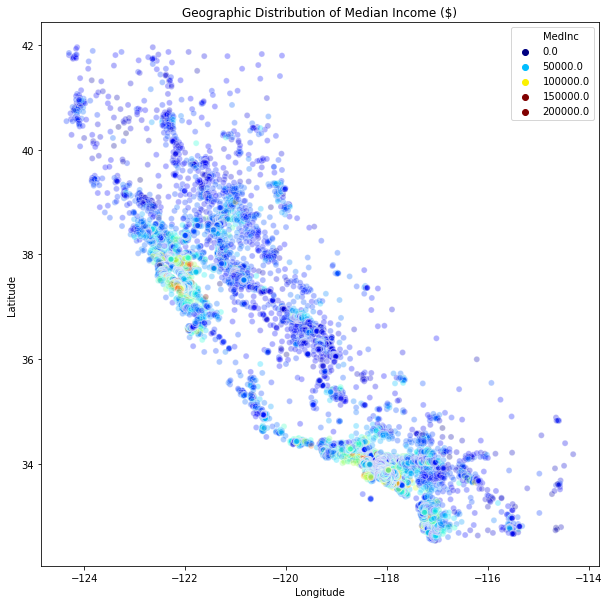

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
sns.scatterplot(x='Longitude', y='Latitude', data=house_df, hue='MedInc', palette='jet', alpha=0.3, ax=ax)
ax.set_title('Geographic Distribution of Median Income ($)')
fig.show()

### Be Aware of Relationships Between Variables and Possible Multicolinearity

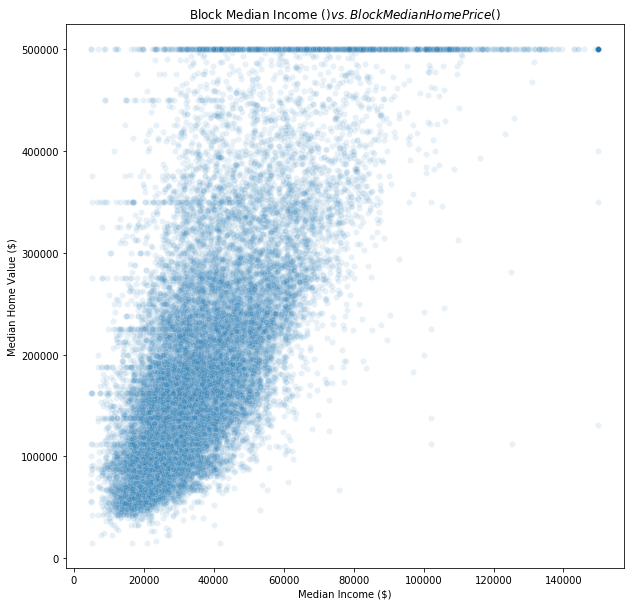

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
sns.scatterplot(x=house_df['MedInc'], y=labels, alpha=0.1, ax=ax)
ax.set_ylabel('Median Home Value ($)')
ax.set_xlabel('Median Income ($)')
ax.set_title("Block Median Income ($) vs. Block Median Home Price ($)")
fig.show()

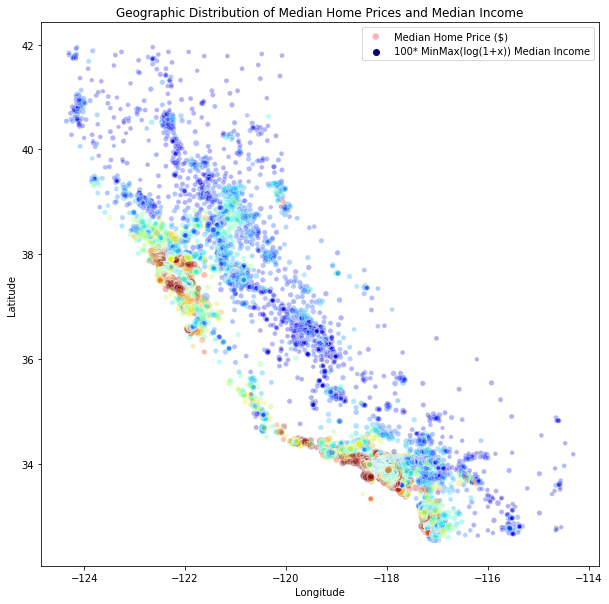

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
sns.scatterplot(x=house_df.Longitude, y=house_df.Latitude,
                hue=labels, size=house_df.MedInc*100, palette='jet', alpha=0.3, ax=ax)
ax.set_title('Geographic Distribution of Median Home Prices and Median Income')
plt.legend(labels=['Median Home Price ($)', '100* MinMax(log(1+x)) Median Income'])
fig.show()

This is a plot of the actual median home value throughout California. We see that distance of a block to the ocean also influences home prices. Ocean proximity may not have as high a correlation with other features in the dataset to allow our models to implicity consider it.

**Note** the np.triu_indeces_from() method returns the indeces of the upper triangle of the matrix passed in - in this case the matrix "mask".

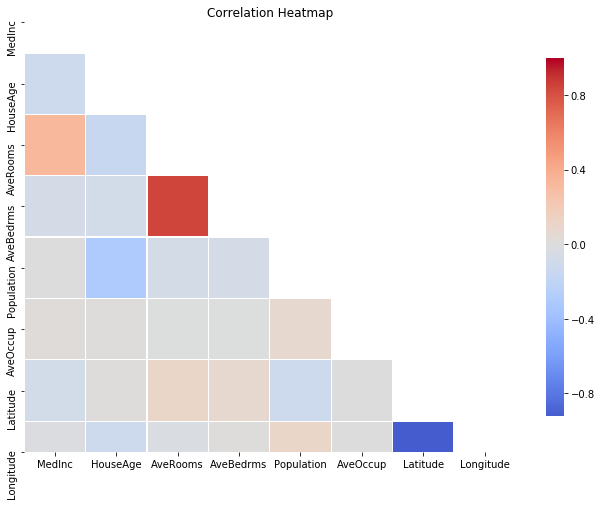

In [10]:
# Calculate correlation matrix of features
corr = house_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(11, 11))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidth=0.2, cbar_kws={"shrink": .6})
ax.set_title('Correlation Heatmap')
fig.show()

### Visualize Distributions of Features to Determine the Best Transformations

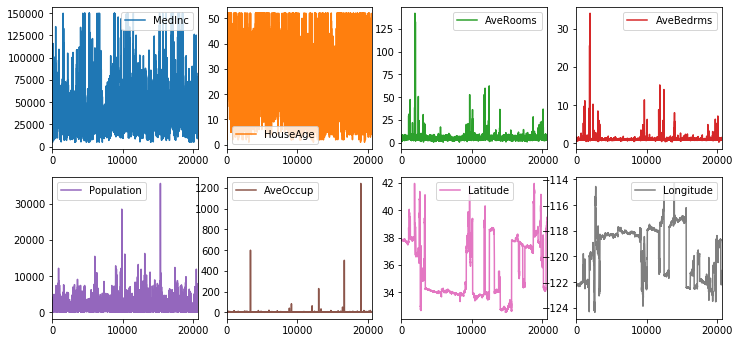

In [11]:
# Plot features to see initial distribution
fig = plt.figure(figsize=(12,12))
ax = plt.gca()
house_df.plot(subplots=True, layout=(4,4), ax=ax)
fig.show()

## Scale, Normalize, and Otherwise Transform Features for Estimation

**Note** Transform Average Occupancy, Average Bedrooms, Average Rooms, Population, and Median Income with the log(1+x) operator to shift data to a more normal distribution. The other features included with the California Housing dataset are more normally distributed and so do not require such a transformation.

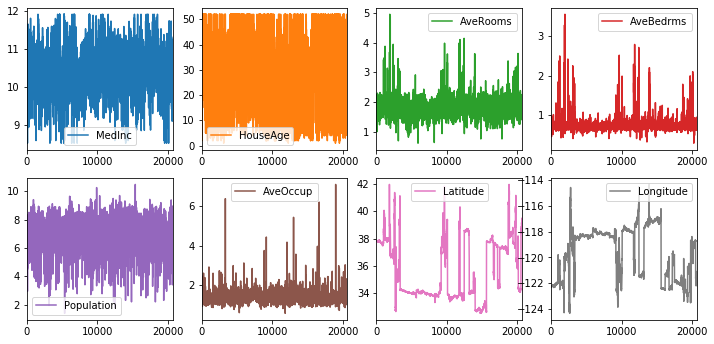

In [12]:
# Log(1+x) transformation on features
house_df['AveOccup'] = np.log1p(house_df['AveOccup'])
house_df['AveBedrms'] = np.log1p(house_df['AveBedrms'])
house_df['AveRooms'] = np.log1p(house_df['AveRooms'])
house_df['Population'] = np.log1p(house_df['Population'])
house_df['MedInc'] = np.log1p(house_df['MedInc'])

# Plot transoformed features to see normalization
fig = plt.figure(figsize=(12,12))
ax = plt.gca()
house_df.plot(subplots=True, layout=(4,4), ax=ax)
fig.show()

Standardize values for all features. There is no need for one-hot encoding in this particular dataset because it does not contain categorical features. I am using MinMaxScaler instead of StandardScaler because the features are not normally distributed, even after transforming features by the log(1+x) operator.

In [13]:
scaler = preprocessing.MinMaxScaler()
house_df = pd.DataFrame(scaler.fit_transform(house_df), columns=cols)

### Use PCA to Prune Unecessary Features

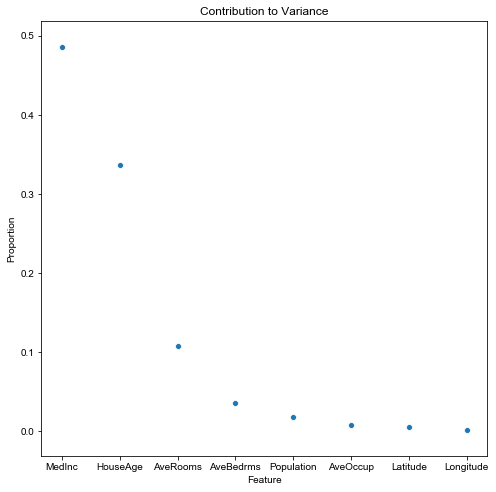

In [14]:
# Calculate principle components
pca = PCA(copy=True)
pca.fit(house_df.values)

# Plot contribution of variance of each feature from PCA
fig = plt.figure(figsize=(8,8))
ax=plt.gca()
sns.set_style('whitegrid')
sns.scatterplot(x=cols, y=pca.explained_variance_ratio_, linestyle='-', ax=ax)
plt.title("Contribution to Variance")
plt.xlabel("Feature")
plt.ylabel("Proportion")
fig.show()

We can see now that AveBedrms, Population, AveOccup, Latitude, and Longitude do not contribute significantly to the variance exhibited by the data. So, we can remove these features. We can choose either AveRooms or AveBedrms to remove because they are highly correlated features. I will not remove any of these features, however, because there are so few that considering the contributions of all eight features is not a strain on computational resources.

In [15]:
x_train, x_test, y_train, y_test = ms.train_test_split(house_df, labels, test_size=0.33, random_state=42)

### Determine Evaluation Metrics

Evaluation metrics vary depending on the type of estimator and the criteria chosen to verify validity. Not all regression problems may need to be compared by their mean square error or mean absolute error, for example. The visualizations used to qualitatively examine model performance are chosen similarly.

In [16]:
def evaluate_model(n_params, y_test, y_score):
    ## Compute adjusted R^2
    r2 = sklm.r2_score(y_test, y_score)
    r2_adj = r2 - (n_params - 1)/(y_test.shape[0] - n_params) * (1 - r2)
    
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_test, y_score)))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_test, y_score)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_test, y_score)))
    print('Adjusted R^2           = ' + str(r2_adj))
    
    # Calculate residuals
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    
    # Plot the KDE of residuals as a subplot
    fig = plt.figure(figsize=(14,8), tight_layout=False)
    gs = gridspec.GridSpec(nrows=1, ncols=2)
    sns.set_style('whitegrid')
    ax = fig.add_subplot(gs[0,0])
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Probability')
    ax.set_title('KDE of Residuals')
    sns.distplot(resids, hist=False, color='skyblue', kde_kws={"shade": True}, ax=ax)
    # Plot the scatter plot of residuals as a subplot
    ax = fig.add_subplot(gs[0,1])
    ax.set_title('Residuals vs. Predicted Values')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residual')
    sns.regplot(y_score, resids, fit_reg=False, color='lightcoral', scatter_kws={'alpha':0.1}, ax=ax)

## Train, Test, and Evaluate Estimators

Choosing the correct estimator for a given problem can be difficult and depends not only on the types of data available and the size of the training dataset, but also on considerations such as balances between bias and variance, interpretability, and resources (time, hardware) and future questions (generalizability).

### A First Attempt at Regression

Model coefficients: [ 543690.5475401    55096.73629041 -216502.37677252  508793.31737565
    5960.96959455 -714428.69206214 -412360.3998178  -438205.87765536]
Model intercept: 288237.18062647665
Mean Square Error      = 5319695876.189882
Mean Absolute Error    = 54971.04018012105
Median Absolute Error  = 43515.71138782888
Adjusted R^2           = 0.6003901004415202


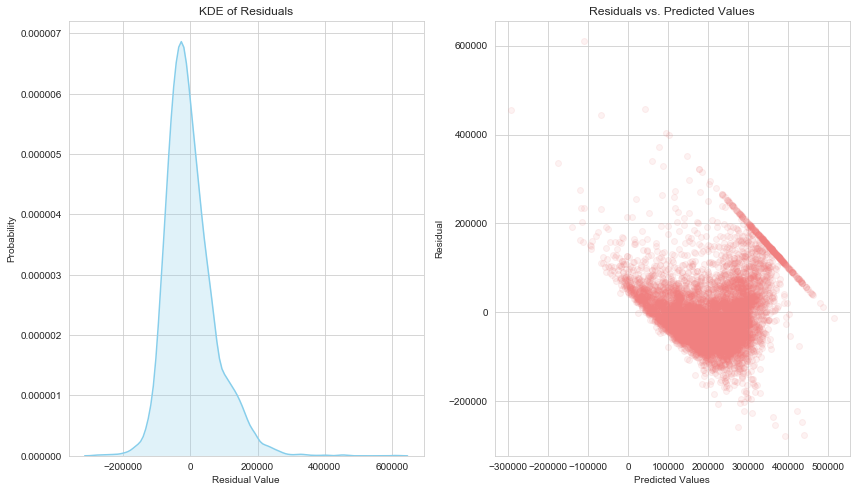

In [17]:
# Unregularized multiple linear regression model
lin_mod = lm.LinearRegression(fit_intercept=True, n_jobs=-1)
lin_mod.fit(x_train, y_train)
print("Model coefficients: {0}".format(lin_mod.coef_))
print("Model intercept: {0}".format(lin_mod.intercept_))
y_score_lin = lin_mod.predict(x_test)
evaluate_model(y_test=y_test, y_score=y_score_lin, n_params=len(house_df.columns))

### Try to Manage the Bias-Variance Tradeoff with Regularization and Cross-Validation

Using ElasticNetCV to incorporate a cross-validated ElasticNet regularization (ElasticNet is meant to encapsulate both ridge (**L2**) regression and lasso (**L1**) regression)

Model Coefficients: [ 531736.31721394   54550.41480209 -172858.41817523  442286.34989384
     839.6853678  -700013.21701676 -411467.98005475 -436048.93983734]

Intercept: 292241.76011033717
Alpha: 20.78360115952025
L1/L2 Ratio Chosen: 1.0
Number of iterations: 287
Mean Square Error      = 5313012197.426722
Mean Absolute Error    = 54955.92644755093
Median Absolute Error  = 43457.55281534701
Adjusted R^2           = 0.6008921712856792


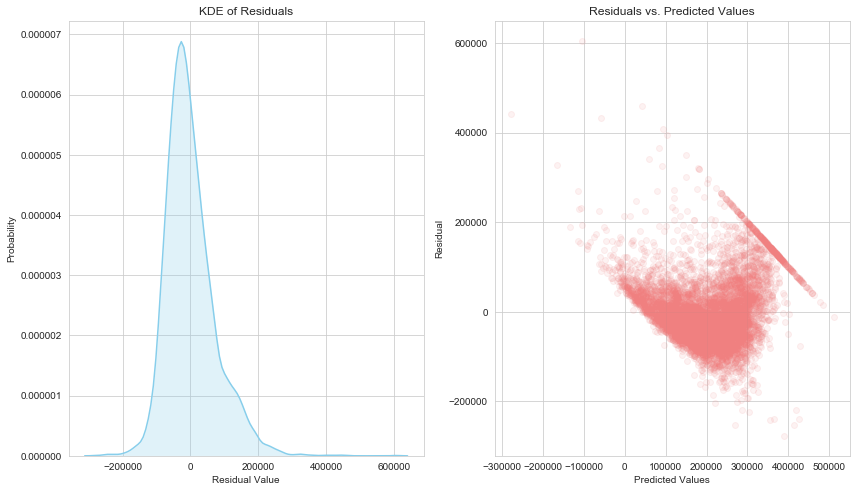

In [18]:
# Cross validation optimization of an ElasticNet regressor
mlr = lm.ElasticNetCV(fit_intercept=True, cv=10, eps=2e-3, n_alphas=1000, copy_X=True,
                   tol=1e-7, l1_ratio=[.1, .3, .5, .53, .59, .65, .7, .9, .93, .95, .99, 1],
                   selection='random', max_iter=1000, n_jobs=-1)
mlr.fit(x_train, y_train)
y_score_elastic = mlr.predict(x_test)
print("Model Coefficients: {0}\n".format(mlr.coef_))
print("Intercept: {0}".format(mlr.intercept_))
print("Alpha: {0}".format(mlr.alpha_))
print("L1/L2 Ratio Chosen: {0}".format(mlr.l1_ratio_))
print("Number of iterations: {0}".format(mlr.n_iter_))
evaluate_model(y_test=y_test, y_score=y_score_elastic, n_params=len(house_df.columns))

We can see that the ElasticNet regression does not handle the data better in a noticeable way. The residuals look to be in an almost identical distribution to those found by standard Multiple Linear Regression run without regularization.

### Try to Capture Nonlinearity Through Regression with More Complicated Models

Trying a SVR model may address issues with managing outliers with different nonlinear kernels, but the number of datapoints is too high to do a thorough cross validation. Maybe we can get better performance through Stochastic Gradient Descent (SGD) . SGD is faster than the standard SVR option in scikit-learn because the sets of parameters are chosen randomly. However, that also means that as the set of parameters descends the gradient of the chosen error surface there is a higher chance of the model skipping over the ideal set of parameters.

Fitting 10 folds for each of 1188 candidates, totalling 11880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 11226 tasks      

Mean Square Error      = 5315999899.049396
Mean Absolute Error    = 54932.29021857582
Median Absolute Error  = 43463.66442692457
Adjusted R^2           = 0.6006677383156118


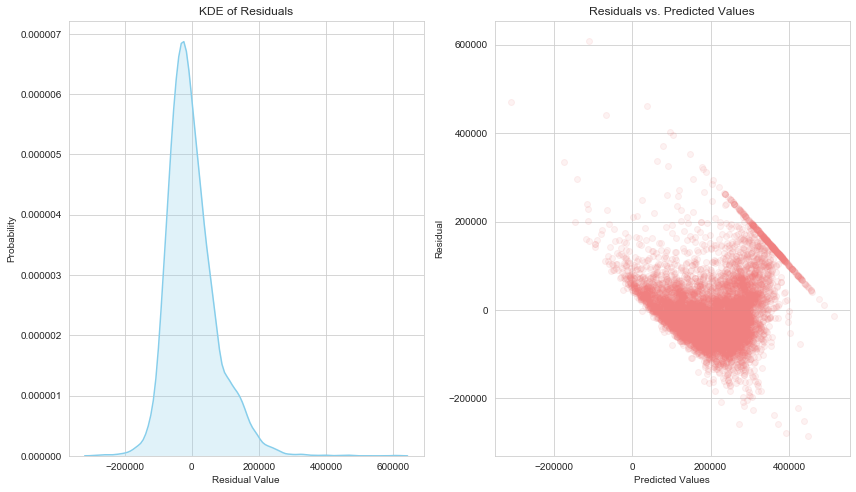

In [19]:
# Cross validation grid search optimization of a stochastic gradient descent regressor
sgd_reg = lm.SGDRegressor(random_state=42, fit_intercept=True, early_stopping=True, n_iter_no_change=100)
p_grid = {   "l1_ratio": [0, 0.15, 0.3, 0.5, 0.85,0.95, 0.98, 0.99, 0.995, 0.999, 1],
              "alpha": [0.0001, 0.001, 0.01, 1, 10, 100],
              "penalty": ["elasticnet", "l1", "l2"], 
              "learning_rate": ["invscaling", "adaptive", "optimal"],
              "eta0": [0.001, 0.01]}
sgd_reg = ms.GridSearchCV(sgd_reg, param_grid=p_grid, cv=10, n_jobs=-1, verbose=True, refit='r2_score')
sgd_reg.fit(x_train, y_train)
sgd_reg = sgd_reg.best_estimator_
sgd_reg.fit(x_train, y_train)
y_score_sgd = sgd_reg.predict(x_test)
evaluate_model(y_test=y_test, y_score=y_score_sgd, n_params=len(house_df.columns))

Stochastic gradient descent regression did not yield results much better than the ElasticNet estimator. This may be because the ideal solution was skipped or because the 

Or even better performance with a Random Forest Regression

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  8.9min finished


Coefficient of determination on training set: 0.6189678634528131
Mean Square Error      = 5179943198.308101
Mean Absolute Error    = 53302.84347170361
Median Absolute Error  = 42957.9698147866
Adjusted R^2           = 0.6108881730515217


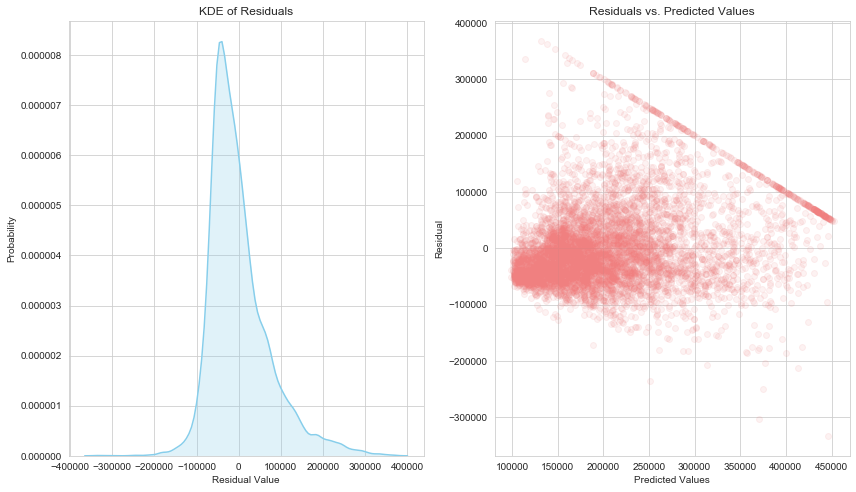

In [20]:
# Cross validation grid search optimization of a ExtraTrees random forest regressor
p_grid = {'n_estimators': [500, 700, 1000],
          'min_samples_split': [0.1, 0.3, 0.5, 0.6],
          'min_samples_leaf': [1, 3, 5, 10, 20],
          'max_features': ['log2', 'sqrt', 'auto']}
reg_et = ms.GridSearchCV(ensemble.ExtraTreesRegressor(warm_start=True, max_depth=None), p_grid, cv=10, 
                   n_jobs=-1, refit='r2_score', verbose=1)
reg_et.fit(x_train, y_train)
reg_et = reg_et.best_estimator_
reg_et.fit(x_train, y_train)
y_score_xtra = reg_et.predict(x_test)
print("Coefficient of determination on training set:", reg_et.score(x_train, y_train))
evaluate_model(y_test=y_test, y_score=y_score_xtra, n_params=len(house_df.columns))

Would a Histogram Gradient Boosted Regression Forest actually be best? The histogram gradient boosting method was chosen because there are over 20,000 samples in the dataset and the histogram binning helps to solve the regression more quickly.

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 15.5min finished


Mean Square Error      = 1972453577.8522484
Mean Absolute Error    = 29121.037445236114
Median Absolute Error  = 18567.985045430716
Adjusted R^2           = 0.8518313838847041


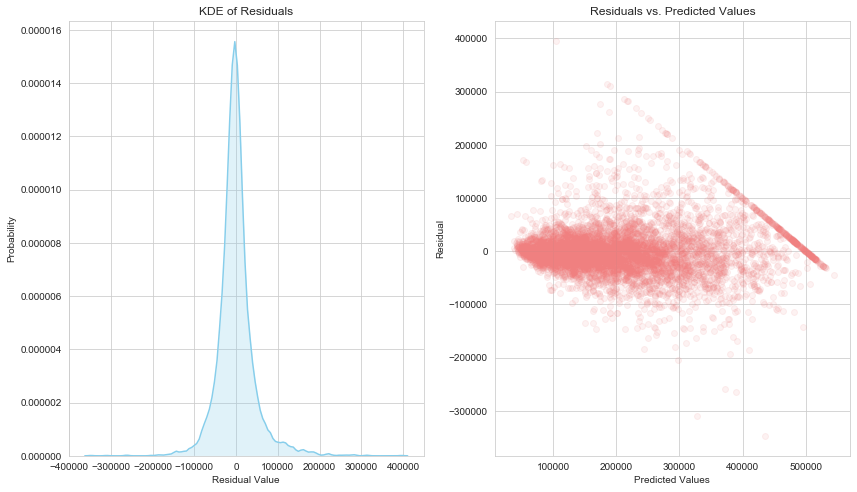

In [21]:
# Cross validation grid search optimization of a histogram gradient boosted regressor
p_grid = {'scoring': ['neg_log_loss', 'max_error'],
          'l2_regularization': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5],
          'learning_rate': [0.001, 0.01, 0.1],
          'max_iter': [500, 700, 1000]}
hist_reg = ensemble.HistGradientBoostingRegressor(random_state=44, loss='least_squares')
hist_reg = ms.GridSearchCV(hist_reg, p_grid, cv=10, n_jobs=-1, verbose=1, refit='r2_score')
hist_reg.fit(x_train, y_train)
hist_reg = hist_reg.best_estimator_
hist_reg.fit(x_train, y_train)
y_score_hist = hist_reg.predict(x_test)
evaluate_model(y_test=y_test, y_score=y_score_hist, n_params=len(house_df.columns))

## Conclusions

Non-regularized multiple linear regression, random forest regression, and stochastic gradient descent regression yielded **~.25 lower coefficients of determination** than that of the Histogram Gradient Boosted Regressor (HGBR) model. Noting the histogram and scatter plot of residual values, we can see that the distribution for all but the HGBR have more variability in the overestimations than the underestimations. This may be explained by failing to consider an imbalance in the original dataset which may result in over-training for less expensive homes, or being unable to determine more precisely how much more expensive a home can be. Data visualization can quickly validate this line of thinking.

In [22]:
# Load test labels and regression estimates into single dataframe
scores = {'True': y_test , 'LinReg': y_score_lin, 'ElasticNet': y_score_elastic,
          'SGD': y_score_sgd, 'ExtraTrees': y_score_xtra,
          'HGBR': y_score_hist}
scores = pd.DataFrame(data=scores)
# Calculate average estimate
scores['Average Estimate'] = scores.iloc[:,1:6].mean(axis=1)

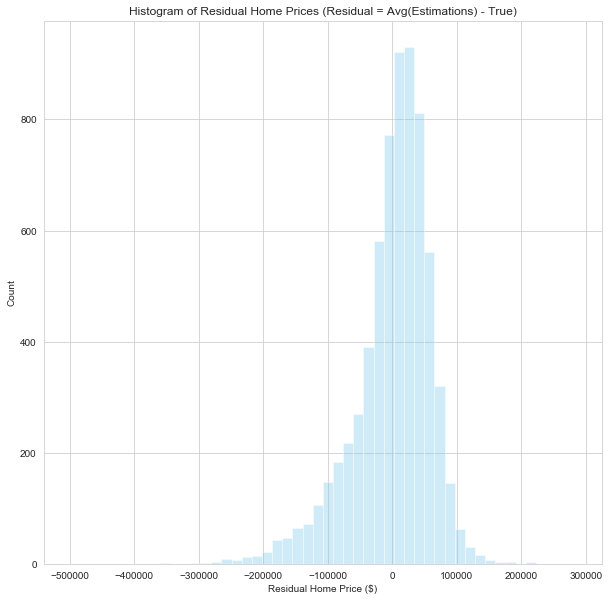

In [23]:
# Histogram of average's residuals
residuals = scores['Average Estimate'] - scores['True']
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
sns.distplot(residuals, color='skyblue', kde=False, ax=ax)
ax.set_title('Histogram of Residual Home Prices (Residual = Avg(Estimations) - True)')
ax.set_xlabel("Residual Home Price ($)")
ax.set_ylabel("Count")
fig.show()

"Average Estimate" is the average estimated median home value of across all regression attempts. The histogram shows the residual of the average estimation. 

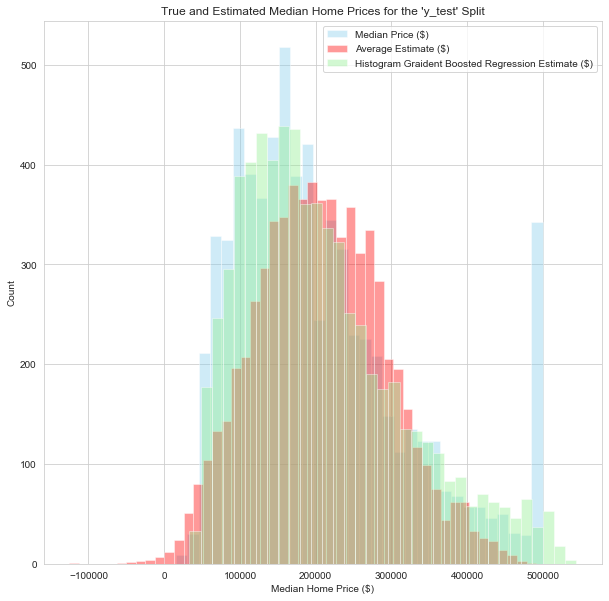

In [24]:
# Median price and avg. estimate histograms together
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
sns.distplot(scores["True"], color="skyblue", label="Median Price ($)", kde=False, kde_kws={"shade": True})
sns.distplot(scores["Average Estimate"], color="red", label="Average Estimate ($)", kde=False, kde_kws={"shade": True})
sns.distplot(scores["HGBR"], color="lightgreen", label="Histogram Graident Boosted Regression Estimate ($)", kde=False,
             kde_kws={"shade": True})
ax.set_xlabel("Median Home Price ($)")
ax.set_ylabel("Count")
ax.set_title("True and Estimated Median Home Prices for the 'y_test' Split")
plt.legend()
fig.show()

With two simple plots we can see that undersampling of less expensive homes was not the likely cause of the high overestimation. Rather, it may be that there are fewer moderately priced homes which skew the results.
However, this does not clarify why the HGBR had a much higher coefficient of determination. That may be answered by studying the parameters optimized with model_selection.GridSearchCV(). HGBR uses multiple estimators, like the ExtraTrees regression models, but the ExtraTrees do not fit to the residual remaining from weak classifiers, only average the outputs of many equally well fit trees. The other estimators are equally weak because they search around the same area in the error surface while HGBR is able to minimize further by acting upon the remaining residual after adding successive trees. We also noted earlier that ocean proximity may have a noticeable impact on predictions.  This missing feature may be responsible for the models' inability to properly learn the large spike in very expensive homes and the few moderately prices homes, where ocean views, beach access, or other related home features can be a key factor in the value of a home, regardless of its size, the population of the block it belongs in, etc.